In [89]:
!pip install tensorflow==2.4.2 
!pip install ternsorflow-gpu==2.4.2 
!pip install opencv-python 
!pip install mediapipe 
!pip install scikit-learn
!pip install matplotlip

ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.2 (from versions: 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==2.4.2
ERROR: Could not find a version that satisfies the requirement ternsorflow-gpu==2.4.2 (from versions: none)
ERROR: No matching distribution found for ternsorflow-gpu==2.4.2


In [90]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [91]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [92]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [93]:
from tensorflow.keras.optimizers import Adam

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [95]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
import os
from tensorflow.keras.layers import Dropout

### Keypoint with Mediapipe

In [96]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [97]:
def mediapipe_detect(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) ## color conversion BGR to RGB
    image.flags.writeable = False ## image is no longer writeable
    results = model.process(image) ## make predictions
    image.flags.writeable = True  ## image is not writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) ## color conversion RGB to BGR
    return image, results

In [98]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
    #                         mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                         mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                         ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

### Extract Keypoint Values

In [99]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

### Setup folders for collection

In [100]:
DATA_PATH = os.path.join('MP_Data')
## actions that we try to detect
actions = np.array(['hello', 'bye','listen', 'look', 'shhh', 'donkey', 'mouse', 'duck', 'hear', 'uncle'])

## thrity videos worth of data
no_sequences = 30

## videos are going to be 30 frames in length
sequence_length = 30

In [13]:
##hello
# 0
#1
#2
#..
#29
##thankyou

##listen

In [10]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

NameError: name 'no_sequences' is not defined

### Collection keypoint values for training and testing

In [61]:
cap = cv2.VideoCapture(1)
##set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence = 0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                ## read feed
                ret, frame= cap.read()

                ##make detections
                image, results = mediapipe_detect(frame, holistic)
                print(results)

                ##draw landmarks
                draw_landmarks(image, results)
                
                if frame_num == 0:
                    cv2.putText(image, 'STARTING_COLLECTION', (120,200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} for video number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'collecting frames for {} video number {}'.format(action, sequence), (15, 12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                
                ## show to screen
                cv2.imshow('OpenCV Feed', image)
                
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1702244535.478567       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M2


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [62]:
cap.release()
cv2.destroyAllWindows()

### Preprocess Data and Create Labels and Features

In [101]:
label_map = {label:num for num, label in enumerate(actions)}

In [102]:
label_map

{'hello': 0,
 'bye': 1,
 'listen': 2,
 'look': 3,
 'shhh': 4,
 'donkey': 5,
 'mouse': 6,
 'duck': 7,
 'hear': 8,
 'uncle': 9}

In [103]:
sequences, labels = [], []

for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [104]:
np.array(sequences).shape

(300, 30, 258)

In [105]:
X = np.array(sequences)

In [106]:
y = to_categorical(labels).astype(int)

In [107]:
## spliting data in train, test and validation - 80% training and 20% test/validation
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5)

In [108]:
X_train.shape

(240, 30, 258)

In [109]:
X_valid.shape

(30, 30, 258)

In [110]:
X_test.shape

(30, 30, 258)

### Build & Train LSTM Neural Network

In [24]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [25]:
model_lstm1 = Sequential()
model_lstm1.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
model_lstm1.add(LSTM(128, return_sequences=True, activation='relu'))
model_lstm1.add(LSTM(64, return_sequences=False, activation='relu'))
model_lstm1.add(Dense(64, activation='relu'))
model_lstm1.add(Dense(32, activation='relu'))
model_lstm1.add(Dense(actions.shape[0], activation='softmax'))

In [26]:
model_lstm1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [27]:
m1 = model_lstm1.fit(X_train, y_train, epochs=80, callbacks=[tb_callback],validation_data=(X_valid, y_valid))

Epoch 1/80
8/8 [==============================] - 3s 96ms/step - loss: 2.3199 - categorical_accuracy: 0.0875 - val_loss: 2.2997 - val_categorical_accuracy: 0.1333
Epoch 2/80
8/8 [==============================] - 0s 37ms/step - loss: 2.2941 - categorical_accuracy: 0.1125 - val_loss: 2.2695 - val_categorical_accuracy: 0.1333
Epoch 3/80
8/8 [==============================] - 0s 38ms/step - loss: 2.2772 - categorical_accuracy: 0.1458 - val_loss: 2.2168 - val_categorical_accuracy: 0.2000
Epoch 4/80
8/8 [==============================] - 0s 37ms/step - loss: 2.2939 - categorical_accuracy: 0.1708 - val_loss: 2.2796 - val_categorical_accuracy: 0.2000
Epoch 5/80
8/8 [==============================] - 0s 37ms/step - loss: 2.2545 - categorical_accuracy: 0.1875 - val_loss: 2.2209 - val_categorical_accuracy: 0.1000
Epoch 6/80
8/8 [==============================] - 0s 38ms/step - loss: 2.2001 - categorical_accuracy: 0.1708 - val_loss: 3.6561 - val_categorical_accuracy: 0.1000
Epoch 7/80
8/8 [======

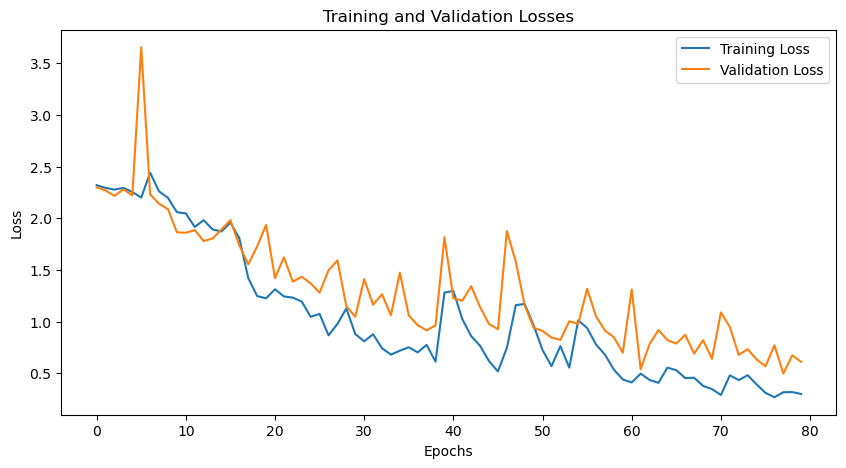

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(m1.history['loss'], label='Training Loss')
plt.plot(m1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

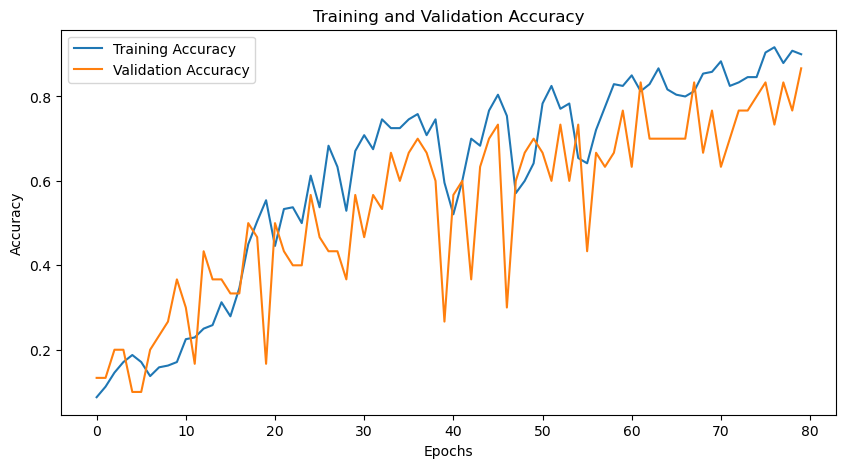

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(m1.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(m1.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [32]:
model_lstm1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            82688     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 237482 (927.66 KB)
Trainable params: 23748

#### Evaluation

In [33]:
yhat = model_lstm1.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
accuracy_score(ytrue, yhat)

1/1 [==============================] - 0s 304ms/step


0.7

#### LSTM with Dropout

In [34]:
model_lstm2 = Sequential()
model_lstm2.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30,258)))
model_lstm2.add(Dropout(0.2))
model_lstm2.add(LSTM(64, return_sequences=True, activation='relu'))
model_lstm2.add(Dropout(0.2))
model_lstm2.add(LSTM(128, return_sequences=True, activation='relu'))
model_lstm2.add(Dropout(0.2))
model_lstm2.add(LSTM(64, return_sequences=False, activation='relu'))
model_lstm2.add(Dense(64, activation='relu'))
model_lstm2.add(Dense(32, activation='relu'))
model_lstm2.add(Dense(actions.shape[0], activation='softmax'))

learning_rate = 0.01  # Define learning rate
optimizer = Adam(learning_rate=learning_rate)
model_lstm2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

m2 = model_lstm2.fit(X_train, y_train, epochs=150, callbacks=[tb_callback],validation_data=(X_valid, y_valid))

Epoch 1/150
8/8 [==============================] - 5s 100ms/step - loss: 14168.4600 - categorical_accuracy: 0.0958 - val_loss: 44019.9805 - val_categorical_accuracy: 0.0667
Epoch 2/150
8/8 [==============================] - 0s 41ms/step - loss: 18755.9121 - categorical_accuracy: 0.0917 - val_loss: 2.3099 - val_categorical_accuracy: 0.0333
Epoch 3/150
8/8 [==============================] - 0s 43ms/step - loss: 2058.9216 - categorical_accuracy: 0.0958 - val_loss: 2.3081 - val_categorical_accuracy: 0.0333
Epoch 4/150
8/8 [==============================] - 0s 46ms/step - loss: 498.1288 - categorical_accuracy: 0.1250 - val_loss: 2.3004 - val_categorical_accuracy: 0.1333
Epoch 5/150
8/8 [==============================] - 0s 49ms/step - loss: 279.7201 - categorical_accuracy: 0.1125 - val_loss: 2.2959 - val_categorical_accuracy: 0.1333
Epoch 6/150
8/8 [==============================] - 0s 41ms/step - loss: 114.6974 - categorical_accuracy: 0.1167 - val_loss: 2.2951 - val_categorical_accuracy: 0

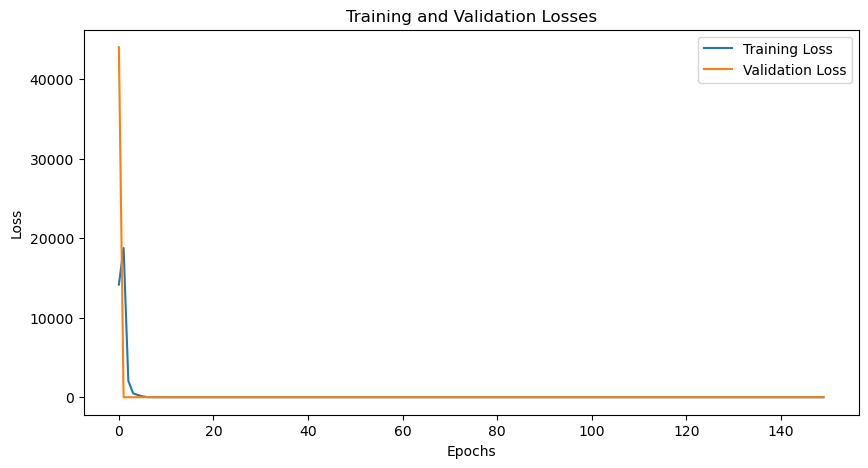

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(m2.history['loss'], label='Training Loss')
plt.plot(m2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

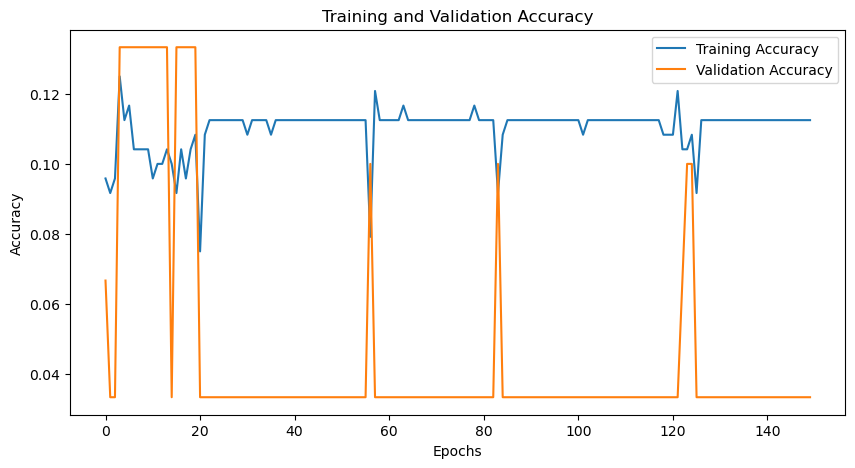

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(m2.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(m2.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Evaluation

In [37]:
yhat = model_lstm2.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
accuracy_score(ytrue, yhat)

1/1 [==============================] - 0s 371ms/step


0.06666666666666667

### Convolution Neural Network

In [111]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

model_cnn1 = Sequential()

# Convolutional layers
model_cnn1.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(30, 258)))
model_cnn1.add(MaxPooling1D(pool_size=2))
model_cnn1.add(Dropout(0.25))

model_cnn1.add(Conv1D(64, kernel_size=3, activation='relu'))
model_cnn1.add(MaxPooling1D(pool_size=2))
model_cnn1.add(Dropout(0.25))

# Flatten layer to transition to a fully connected layer
model_cnn1.add(Flatten())

# Fully connected layers
model_cnn1.add(Dense(64, activation='relu'))
model_cnn1.add(Dense(32, activation='relu'))

# Output layer
model_cnn1.add(Dense(actions.shape[0], activation='softmax'))
learning_rate = 0.01  # Define learning rate
optimizer = Adam(learning_rate=learning_rate)
# Compile the model
model_cnn1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Train the model
#model2.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

In [112]:
history = model_cnn1.fit(X_train, y_train, epochs=80, callbacks=[tb_callback], validation_data=(X_valid, y_valid))

Epoch 1/80
8/8 [==============================] - 1s 24ms/step - loss: 2.6395 - categorical_accuracy: 0.0625 - val_loss: 2.3028 - val_categorical_accuracy: 0.1000
Epoch 2/80
8/8 [==============================] - 0s 5ms/step - loss: 2.3039 - categorical_accuracy: 0.1042 - val_loss: 2.3060 - val_categorical_accuracy: 0.1000
Epoch 3/80
8/8 [==============================] - 0s 5ms/step - loss: 2.3025 - categorical_accuracy: 0.1042 - val_loss: 2.3123 - val_categorical_accuracy: 0.1000
Epoch 4/80
8/8 [==============================] - 0s 5ms/step - loss: 2.3010 - categorical_accuracy: 0.1042 - val_loss: 2.3157 - val_categorical_accuracy: 0.1000
Epoch 5/80
8/8 [==============================] - 0s 5ms/step - loss: 2.3009 - categorical_accuracy: 0.0958 - val_loss: 2.3170 - val_categorical_accuracy: 0.0333
Epoch 6/80
8/8 [==============================] - 0s 6ms/step - loss: 2.2998 - categorical_accuracy: 0.1167 - val_loss: 2.3190 - val_categorical_accuracy: 0.0333
Epoch 7/80
8/8 [===========

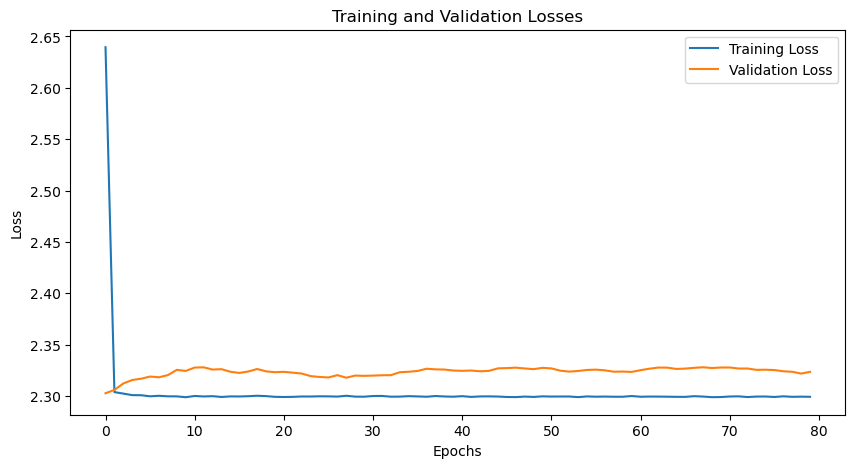

In [113]:
# Plotting training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

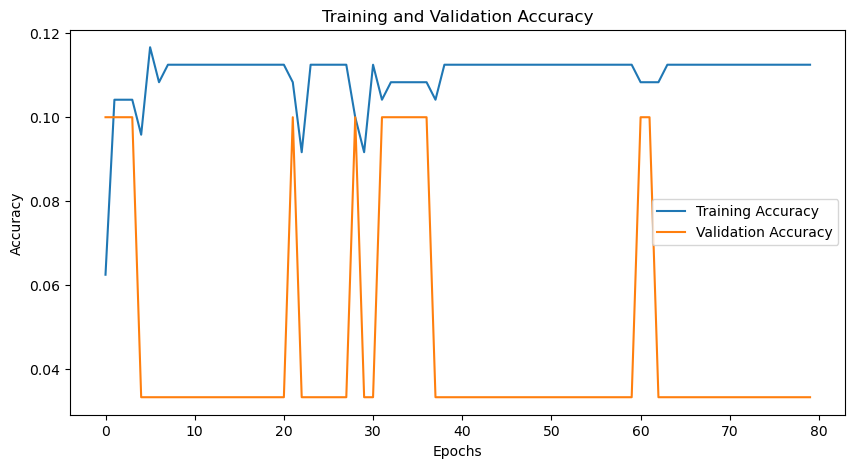

In [114]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [115]:
model_cnn1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 28, 32)            24800     
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 14, 32)            0         
 ng1D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 14, 32)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 12, 64)            6208      
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 6, 64)             0         
 ng1D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 6, 64)            

#### Evaluation

In [116]:
yhat = model_cnn1.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
accuracy_score(ytrue, yhat)

1/1 [==============================] - 0s 67ms/step


0.06666666666666667

### CNN with more layers

In [117]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

model_cnn2 = Sequential()

# Convolutional layers
model_cnn2.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(30, 258)))
model_cnn2.add(MaxPooling1D(pool_size=2))
model_cnn2.add(Dropout(0.25))

model_cnn2.add(Conv1D(128, kernel_size=3, activation='relu'))
model_cnn2.add(MaxPooling1D(pool_size=2))
model_cnn2.add(Dropout(0.25))

# Flatten layer to transition to a fully connected layer
model_cnn2.add(Flatten())

# Fully connected layers
model_cnn2.add(Dense(128, activation='relu'))
model_cnn2.add(Dense(64, activation='relu'))

# Output layer
model_cnn2.add(Dense(actions.shape[0], activation='softmax'))

learning_rate = 0.001  # Define learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model_cnn2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history2 = model_cnn2.fit(X_train, y_train, epochs=200, callbacks=[tb_callback], validation_data=(X_valid, y_valid))

Epoch 1/200
8/8 [==============================] - 1s 24ms/step - loss: 2.3763 - categorical_accuracy: 0.1042 - val_loss: 2.3282 - val_categorical_accuracy: 0.0667
Epoch 2/200
8/8 [==============================] - 0s 6ms/step - loss: 2.3247 - categorical_accuracy: 0.0875 - val_loss: 2.3217 - val_categorical_accuracy: 0.1000
Epoch 3/200
8/8 [==============================] - 0s 6ms/step - loss: 2.3001 - categorical_accuracy: 0.1250 - val_loss: 2.2999 - val_categorical_accuracy: 0.1667
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 2.2694 - categorical_accuracy: 0.1625 - val_loss: 2.2933 - val_categorical_accuracy: 0.2667
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 2.2417 - categorical_accuracy: 0.1833 - val_loss: 2.2801 - val_categorical_accuracy: 0.1667
Epoch 6/200
8/8 [==============================] - 0s 8ms/step - loss: 2.2311 - categorical_accuracy: 0.1667 - val_loss: 2.2533 - val_categorical_accuracy: 0.2667
Epoch 7/200
8/8 [====

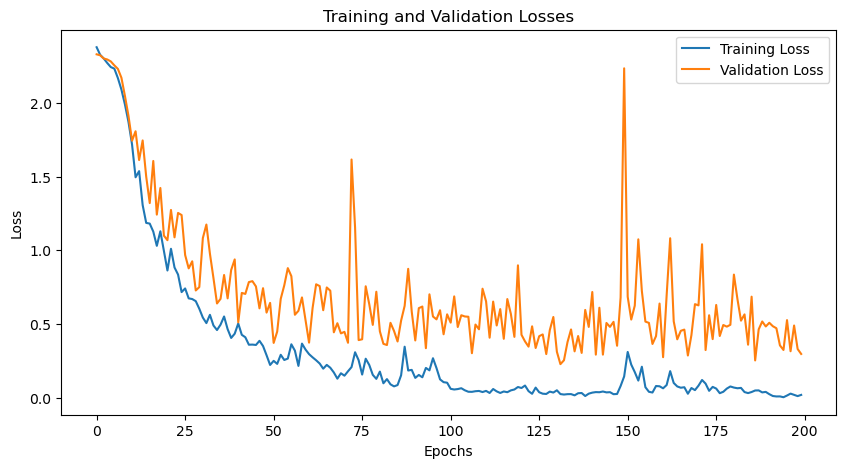

In [118]:
# Plotting training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

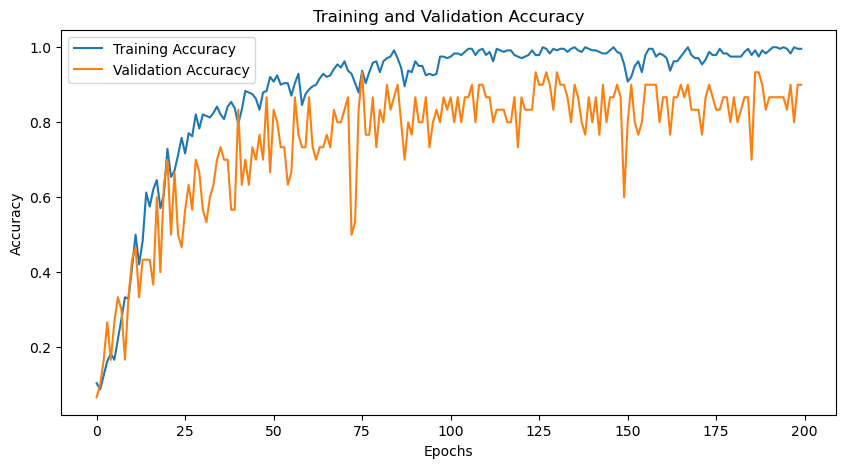

In [119]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history2.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Evaluation

In [120]:
test_loss, test_accuracy = model_cnn2.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 15ms/step - loss: 0.6007 - categorical_accuracy: 0.8667
Test Loss: 0.6007387042045593
Test Accuracy: 0.8666666746139526


### CNN with Learning Rate Scheduler

In [72]:
from tensorflow.keras.callbacks import LearningRateScheduler
import math

# Define a function to schedule the learning rate
def scheduler(epoch, lr):
    # You can define your own scheduling logic here
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model_cnn2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with the learning rate scheduler
history3 = model_cnn2.fit(X_train, y_train, epochs=200, callbacks=[tb_callback, lr_scheduler], validation_data=(X_valid, y_valid))

Epoch 1/200
8/8 [==============================] - 1s 24ms/step - loss: 0.0943 - categorical_accuracy: 0.9625 - val_loss: 0.5099 - val_categorical_accuracy: 0.8667 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1242 - categorical_accuracy: 0.9625 - val_loss: 0.7238 - val_categorical_accuracy: 0.7667 - lr: 0.0010
Epoch 3/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1394 - categorical_accuracy: 0.9458 - val_loss: 0.6789 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 4/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0732 - categorical_accuracy: 0.9833 - val_loss: 0.5019 - val_categorical_accuracy: 0.9000 - lr: 0.0010
Epoch 5/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0298 - categorical_accuracy: 0.9958 - val_loss: 0.5035 - val_categorical_accuracy: 0.8333 - lr: 0.0010
Epoch 6/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0386 - categorical_accuracy: 0.9875 - val_loss

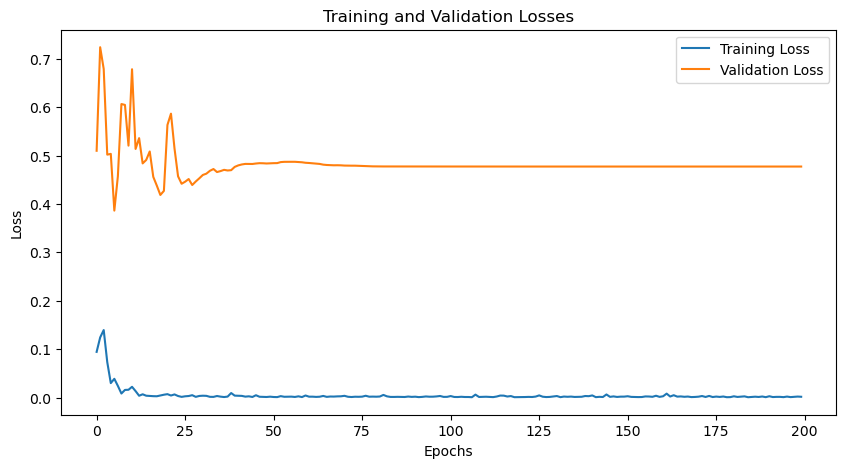

In [73]:
# Plotting training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

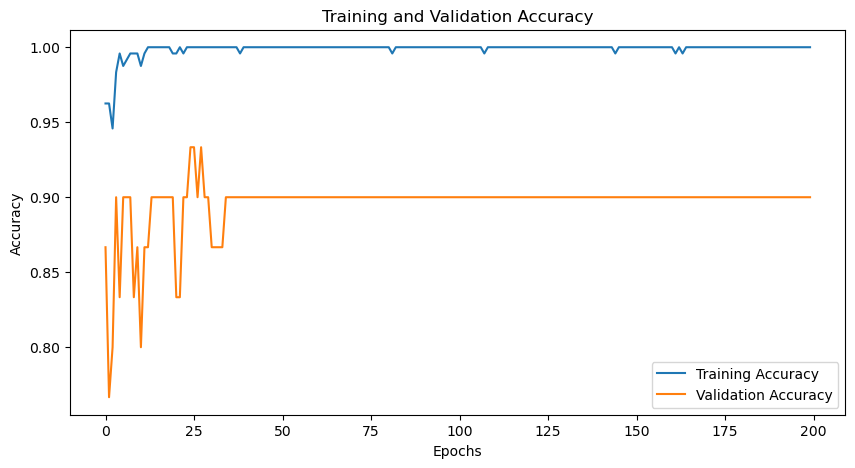

In [74]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history3.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Evaluation

In [75]:
test_loss, test_accuracy = model_cnn2.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 14ms/step - loss: 0.7377 - categorical_accuracy: 0.9000
Test Loss: 0.7376978397369385
Test Accuracy: 0.8999999761581421


### CNN with Regularization

In [53]:
from tensorflow.keras import regularizers

# Define the model with L2 weight regularization
model_cnn3 = Sequential()

# Convolutional layers with L2 regularization
model_cnn3.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(30, 258), kernel_regularizer=regularizers.l2(0.01)))
model_cnn3.add(MaxPooling1D(pool_size=2))
model_cnn3.add(Dropout(0.25))

model_cnn3.add(Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn3.add(MaxPooling1D(pool_size=2))
model_cnn3.add(Dropout(0.25))

# Flatten layer to transition to a fully connected layer
model_cnn3.add(Flatten())

# Fully connected layers with L2 regularization
model_cnn3.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn3.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Output layer
model_cnn3.add(Dense(actions.shape[0], activation='softmax'))

# Compile the model
model_cnn3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Train the model
history4 = model_cnn3.fit(X_train, y_train, epochs=300, callbacks=[tb_callback], validation_data=(X_valid, y_valid))


Epoch 1/300
8/8 [==============================] - 1s 26ms/step - loss: 7.0328 - categorical_accuracy: 0.0833 - val_loss: 6.6007 - val_categorical_accuracy: 0.0667
Epoch 2/300
8/8 [==============================] - 0s 7ms/step - loss: 6.3771 - categorical_accuracy: 0.1000 - val_loss: 5.9862 - val_categorical_accuracy: 0.2667
Epoch 3/300
8/8 [==============================] - 0s 8ms/step - loss: 5.8032 - categorical_accuracy: 0.1292 - val_loss: 5.5212 - val_categorical_accuracy: 0.1333
Epoch 4/300
8/8 [==============================] - 0s 7ms/step - loss: 5.3131 - categorical_accuracy: 0.1292 - val_loss: 5.0898 - val_categorical_accuracy: 0.1667
Epoch 5/300
8/8 [==============================] - 0s 8ms/step - loss: 4.8951 - categorical_accuracy: 0.1333 - val_loss: 4.6865 - val_categorical_accuracy: 0.1333
Epoch 6/300
8/8 [==============================] - 0s 8ms/step - loss: 4.5483 - categorical_accuracy: 0.1417 - val_loss: 4.3652 - val_categorical_accuracy: 0.1667
Epoch 7/300
8/8 [====

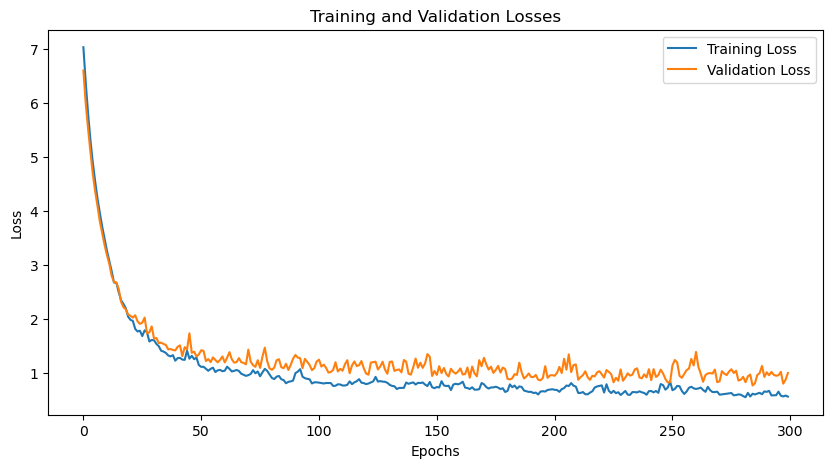

In [54]:
# Plotting training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

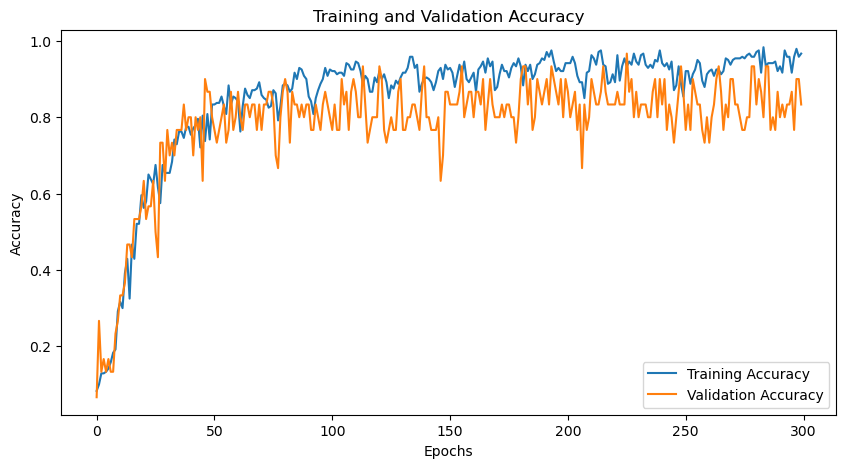

In [55]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history4.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Evaluation

In [56]:
test_loss, test_accuracy = model_cnn3.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 17ms/step - loss: 1.1536 - categorical_accuracy: 0.7333
Test Loss: 1.1536176204681396
Test Accuracy: 0.7333333492279053


### Transformer

In [57]:
import tensorflow as tf
from tensorflow.keras import layers

# Assuming X_train, y_train, X_valid, y_valid are your training and validation data

# Multi-Head Self-Attention Layer
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

# Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Transformer Model
class TransformerModel(tf.keras.Model):
    def __init__(self, num_transformer_blocks, embed_dim, num_heads, dff, num_classes):
        super(TransformerModel, self).__init__()
        self.num_transformer_blocks = num_transformer_blocks
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, dff) for _ in range(num_transformer_blocks)]
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training):
        x = inputs
        for i in range(self.num_transformer_blocks):
            x = self.transformer_blocks[i](x, training)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.output_layer(x)

import tensorflow as tf

def get_transformer_model(input_shape=(30, 258), num_heads=4, dff=1024, num_blocks=2, num_classes=10, dropout=0.2):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    
    # Transformer blocks
    for _ in range(num_blocks):
        # Multi-head self-attention
        attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[1])(x, x)
        attn_output = tf.keras.layers.Dropout(dropout)(attn_output)
        out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Feed-forward network
        ffn = tf.keras.layers.Dense(dff, activation='relu')(out1)
        ffn = tf.keras.layers.Dense(input_shape[1])(ffn)
        ffn = tf.keras.layers.Dropout(dropout)(ffn)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)
    
    # Global average pooling and classification
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    # Build the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='transformer_model')
    return model

# Create the model
transformer_model = get_transformer_model()

# Compile the model
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
transformer_model.summary()


Model: "transformer_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 258)]            0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 30, 258)              1068378   ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 dropout_11 (Dropout)        (None, 30, 258)              0         ['multi_head_attention[0][0]']
                                                                                                  
 tf.__operators__.add (TFOp  (None, 30, 258)              0         ['input_1[0][0

In [58]:
history_transformer1 = transformer_model.fit(
    X_train, y_train,
    epochs=300,
    callbacks=[tb_callback],  # Assuming lr_scheduler is defined
    validation_data=(X_valid, y_valid)
)

Epoch 1/300
8/8 [==============================] - 3s 192ms/step - loss: 4.7010 - accuracy: 0.1208 - val_loss: 2.9230 - val_accuracy: 0.2000
Epoch 2/300
8/8 [==============================] - 1s 169ms/step - loss: 3.2031 - accuracy: 0.0833 - val_loss: 2.7757 - val_accuracy: 0.0333
Epoch 3/300
8/8 [==============================] - 1s 192ms/step - loss: 2.5483 - accuracy: 0.0958 - val_loss: 2.2013 - val_accuracy: 0.1667
Epoch 4/300
8/8 [==============================] - 1s 184ms/step - loss: 2.3840 - accuracy: 0.1000 - val_loss: 2.5607 - val_accuracy: 0.0333
Epoch 5/300
8/8 [==============================] - 1s 189ms/step - loss: 2.3896 - accuracy: 0.0958 - val_loss: 2.3666 - val_accuracy: 0.1333
Epoch 6/300
8/8 [==============================] - 1s 189ms/step - loss: 2.3501 - accuracy: 0.0625 - val_loss: 2.3569 - val_accuracy: 0.1667
Epoch 7/300
8/8 [==============================] - 1s 182ms/step - loss: 2.3690 - accuracy: 0.0833 - val_loss: 2.3537 - val_accuracy: 0.1333
Epoch 8/300
8

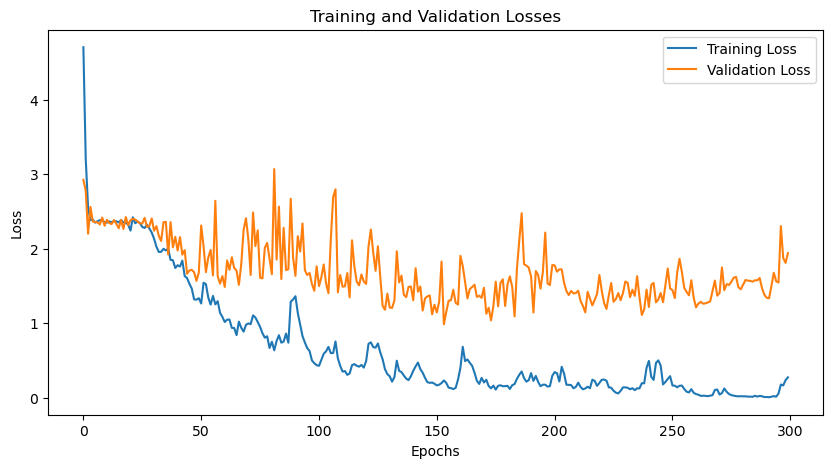

In [59]:
# Plotting training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_transformer1.history['loss'], label='Training Loss')
plt.plot(history_transformer1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

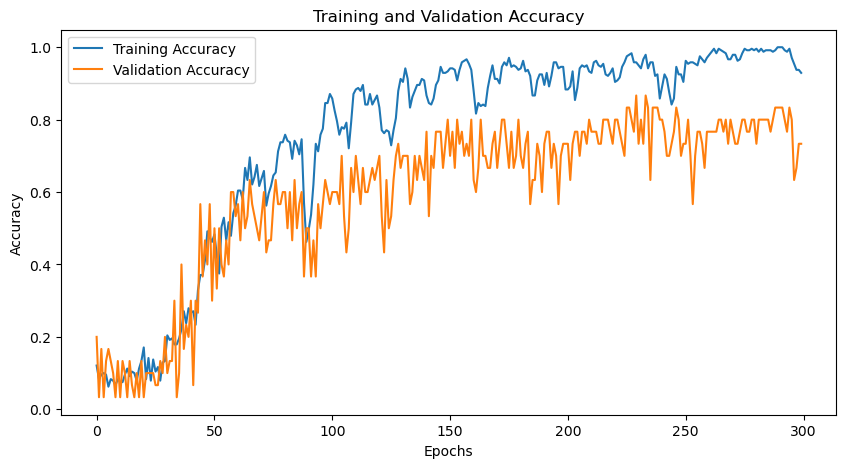

In [60]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_transformer1.history['accuracy'], label='Training Accuracy')
plt.plot(history_transformer1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Evaluation

In [61]:
test_loss, test_accuracy = transformer_model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 66ms/step - loss: 1.9448 - accuracy: 0.7000
Test Loss: 1.9447572231292725
Test Accuracy: 0.699999988079071


### Save Weights

In [62]:
model_cnn2.save('action_cnn.h5')

/Users/chhavisharma/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
#del model_cnn2

In [81]:
model.load_weights('action_cnn.h5')

NameError: name 'model' is not defined

### Test in real time

In [84]:
from scipy import stats

In [85]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [87]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(1)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detect(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model_cnn2.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1702276099.405397       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M2


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

IndexError: list index out of range

In [88]:
cap.release()
cv2.destroyAllWindows()